# Debugging the Pipline

in this notebook we want to get our pipeline up and running and test the key components




In [38]:
%load_ext autoreload
%autoreload 2
%cd /mnt/activeCell-ACDC

#import sys
#sys.path.append("..")

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor

from src.globals import *
from src.visualization.show_image import show_image
from src.register_datasets import register_datasets, get_dataset_name
from src.test import do_test
from src.train import do_train
from src.predict import predict_image_in_acdc
from src.config_builder import get_config



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/mnt/activeCell-ACDC


## Convert ACDC data to COCO format

check coco json file:

In [40]:
with open("./data/acdc_last_images/test/cell_acdc_coco_ds.json") as file:
    train_dict = json.load(file)

In [41]:
print(list(train_dict.keys()),"\n")
print(json.dumps(train_dict["info"], indent=4))
if False:
    print("\ncategories:\n",json.dumps(train_dict["categories"], indent=4))
    print("\nimages:\n",json.dumps(train_dict["images"][0], indent=4))
    print("\nannotations:\n",json.dumps(train_dict["annotations"][0], indent=4))


['info', 'licenses', 'categories', 'images', 'annotations'] 

{
    "description": "cellpose data in COCO format",
    "url": "",
    "version": "0.1.0",
    "year": 2022,
    "contributor": "Florian Bridges",
    "date_created": "2022-12-03 21:32:27.327200"
}


Show some raw images:

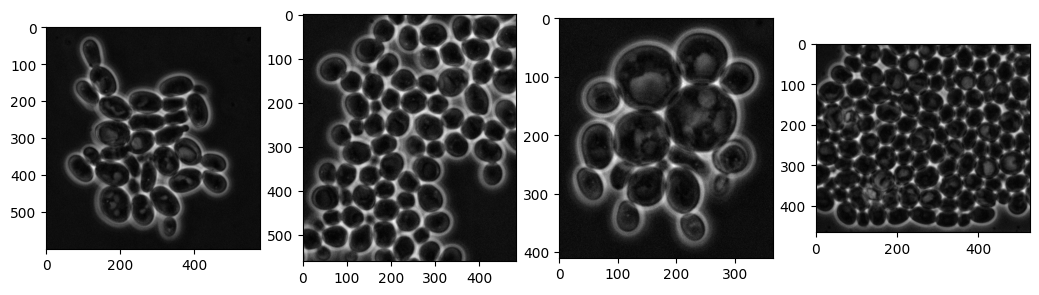

['acdc_data3_20211029_pos_1_200.png', 'acdc_data2_F016_pos_2_160.png', 'acdc_data3_20211029_pos_24_200.png', 'acdc_data3_Yagya_SCGE_WT_pos_4_229.png']


In [43]:
rd.seed(1337)
images_meta_data = rd.sample(train_dict["images"], 4)
imgs = [mpimg.imread("./data/acdc_last_images/test/images/" + image["file_name"]) for image in images_meta_data]
show_image(imgs)
print([image["file_name"] for image in images_meta_data])


## Detectron2

### Register Datasets

In [44]:
register_datasets()

registering acdc_large dataset
registering acdc_small dataset
registering cellpose dataset
registering acdc_last_images dataset


### Inspect Groundtruth


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



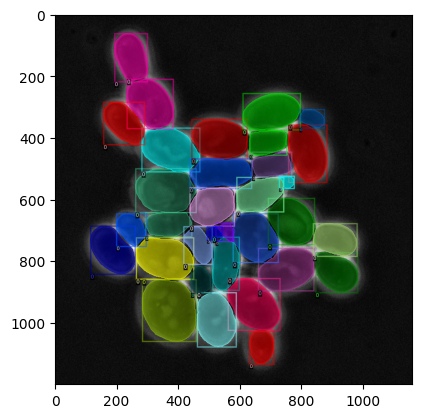

40


In [47]:
cfg = get_cfg()
cfg.DATASETS.TRAIN = (get_dataset_name(ACDC_LAST_IMAGES,TRAIN),)

in_image_id = images_meta_data[0]["id"]
in_image_json = list(filter(lambda image: image["image_id"] == in_image_id, DatasetCatalog.get(get_dataset_name(ACDC_LAST_IMAGES,TEST))))[0]
in_image = cv2.imread(in_image_json["file_name"]) #imgs[0]
visualizer = Visualizer(in_image[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2)
out = visualizer.draw_dataset_dict(in_image_json)
out_image = out.get_image()[:, :, ::-1]
show_image(out_image)
print(in_image_id)


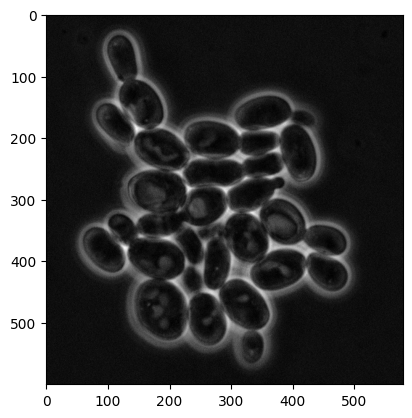

In [48]:
show_image(in_image)

In [81]:
cfg = get_config("acdc_large_full_ds")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "torch_model.pt")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

#from IPython.display import Image

im = cv2.imread(DatasetCatalog.get(get_dataset_name(ACDC_LAST_IMAGES,TEST))[0]["file_name"])

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image([im,out.get_image()[:, :, ::-1]])

TypeError: argument of type 'GeneralizedRCNN' is not iterable

In [50]:
evaluator = COCOEvaluator(get_dataset_name(ACDC_LAST_IMAGES,TEST), output_dir=cfg.OUTPUT_DIR)
data_loader = build_detection_test_loader(cfg, get_dataset_name(ACDC_LAST_IMAGES,TEST))
evaluator = COCOEvaluator(get_dataset_name(ACDC_LAST_IMAGES,TEST), output_dir=cfg.OUTPUT_DIR)
results_i = inference_on_dataset(predictor.model, data_loader, evaluator)
print(results_i)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.654
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.759
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.768
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.

In [51]:
results_i

OrderedDict([('bbox',
              {'AP': 65.37969663196493,
               'AP50': 77.90484829108568,
               'AP75': 75.85823725164933,
               'APs': 37.33929705147742,
               'APm': 75.01356901281277,
               'APl': 76.8334010658591}),
             ('segm',
              {'AP': 67.29685595528744,
               'AP50': 77.96550301394909,
               'AP75': 76.89397131802846,
               'APs': 37.85821282751591,
               'APm': 77.36762458546164,
               'APl': 79.72963010586774})])

In [52]:
%%capture
result_array = []
ds_json = DatasetCatalog.get(get_dataset_name(ACDC_LAST_IMAGES,TEST))
for image_id in [image["image_id"] for image in ds_json]:
    result = evaluator.evaluate(image_id)
    result_array.append(result)
print(result_array)
aps = [result['segm']['AP'] for result in result_array]
worse_aps_ids = [aps.index(ap) for ap in aps if ap < 70]
print(worse_aps_ids)

In [76]:
print(min(aps))
worse_aps_ids = [aps.index(ap) for ap in aps if ap < 70]
worse_aps_ids

46.36014783003128


[2, 4, 7, 11, 12, 15, 22, 23, 29, 30, 31, 34, 36, 37, 41, 42]

## Some of the worse performing Images

In [13]:
#worse_aps_ids = [aps.index(ap) for ap in aps if ap < 75]
worse_aps_ids = list(set(worse_aps_ids))


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



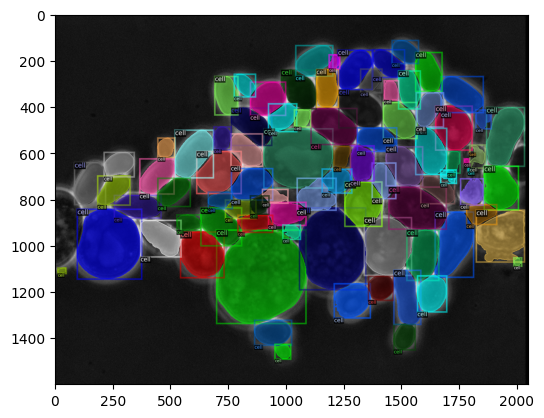

./data/acdc_last_images/test/images/acdc_data3_20210722_pos_2_200.png


In [79]:
def plot_ground_truth(image_json):

    in_image = cv2.imread(image_json["file_name"])
    visualizer = Visualizer(in_image[:, :, ::-1], metadata=MetadataCatalog.get(get_dataset_name(ACDC_LAST_IMAGES,TEST)), scale=2)
    out = visualizer.draw_dataset_dict(image_json)
    out_image = out.get_image()[:, :, ::-1]
    #show_image([in_image,out_image])
    show_image(out_image)

worse_id = 12
image_json = DatasetCatalog.get(get_dataset_name(ACDC_LAST_IMAGES,TEST))[worse_id]
plot_ground_truth(image_json)
print(image_json["file_name"])

In [ ]:
def plot_prediction(image_json):
    cfg = get_config("acdc_large_full_ds")
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0039999.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
    predictor = DefaultPredictor(cfg)

    #from IPython.display import Image

    im = cv2.imread(image_json["file_name"])

    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    show_image([im,out.get_image()[:, :, ::-1]])
                    
                
worse_id = 12
image_json = DatasetCatalog.get(get_dataset_name(ACDC_LAST_IMAGES,TEST))[worse_id]
plot_prediction(image_json)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [24]:
ds_json = DatasetCatalog.get(get_dataset_name(ACDC_LARGE,TEST))
list_ = []
for id in worse_aps_ids:
    list_.append("_".join(ds_json[id]["file_name"].split("_")[:-1]).split("/")[-1])

    print(ds_json[id]["file_name"], id)
    
print(list(set(list_)))


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_1_1.png 14
./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_5_285.png 70
./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_5_261.png 152
./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_5_288.png 161
./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_5_274.png 227
./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_1_40.png 230
./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_1_1.png 14
./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_5_277.png 256
./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_5_282.png 383
./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_1_41.png 412
./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_5_278.png 473
./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_1_320.png 511
./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_5_281.png 572
./data/acdc_large/test/images/acdc_data3_Yagya_SCGE_WT_pos_1

In [16]:
ds_json = DatasetCatalog.get(get_dataset_name(ACDC_LARGE,TEST))


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.




Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



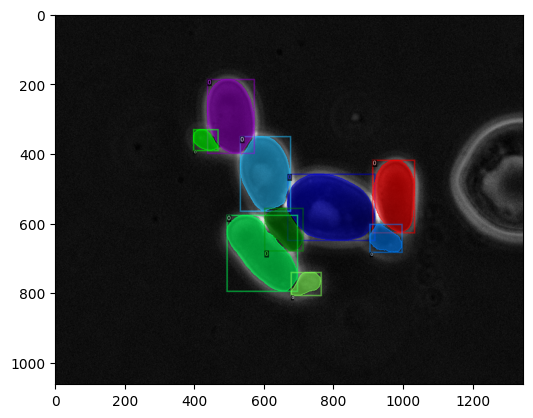

In [17]:
plot_ground_truth(DatasetCatalog.get(get_dataset_name(ACDC_LARGE,TRAIN))[100])



In [18]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

#from IPython.display import Image
im = cv2.imread(DatasetCatalog.get(TEST_DATASET_FULL)[worse_aps_ids[worse_id]]["file_name"])

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image([im,out.get_image()[:, :, ::-1]])

AssertionError: Checkpoint ./output/acdc_large_full_ds/model_final.pth not found!

In [ ]:
show_image(out.get_image()[:, :, ::-1])

## Back to ACDC format

In [ ]:
show_image(predict_image_in_acdc(cfg,im),normalize=False)

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

#from IPython.display import Image
im = cv2.imread(DatasetCatalog.get(TEST_DATASET_FULL)[164]["file_name"])
im = im + 40 * np.random.rand(im.shape[0],im.shape[1],im.shape[2])

outputs = predictor(im)
predictions = outputs["instances"].to("cpu")
predictions.remove("scores")
predictions.remove("pred_classes")
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("cell_acdc_validation_slim"), scale=1.2)
out = v.draw_instance_predictions(predictions)
show_image(out.get_image()[:, :, ::-1], normalize=False)

In [ ]:
im = cv2.imread(DatasetCatalog.get("cell_acdc_validation_slim")[0]["file_name"])
show_image(im)

In [ ]:
res = outputs["instances"].to("cpu").remove("scores")

In [ ]:
outputs["instances"].to("cpu").scores

In [ ]:
object_methods = [method_name for method_name in dir(outputs["instances"].to("cpu"))
                  if callable(getattr(outputs["instances"].to("cpu"), method_name))]

In [ ]:
res = outputs["instances"].to("cpu")

In [ ]:
res.remove("pred_classes")

In [ ]:
res

In [ ]:
import numpy as np